In [89]:
import os
import sys

from pathlib import Path

# si aggiunge al path la cartella utils per avere visibilità del modulo
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [90]:
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.semi_hard_mining as shm

from torch import nn
from tqdm import tqdm
from skimage import io
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [91]:
# serve per ricaricare automaticamente il codice modificato
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

BATCH_SIZE = 32

LR = 0.001

EPOCHS = 30

DEVICE = "cpu"

In [ ]:
real_csv_path = os.path.join("..", "datasets", "real.csv")
fake_csv_path = os.path.join("..", "datasets", "fake.csv")

df_real = pd.read_csv(real_csv_path)
df_fake = pd.read_csv(fake_csv_path)

In [93]:
csv_path = os.path.join("..", "datasets", "out.csv")


df = pd.read_csv(csv_path)

df = df.sample(frac=1)

df.head()

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

print(f"train dataset size: {len(train_df)}")
print(f"val dataset size: {len(valid_df)}")

train dataset size: 16000
val dataset size: 4000


In [94]:
# carica le immagini nel dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if "tt" in row.Anchor:
        A_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        N_img = io.imread(os.path.join(real_data_dir, row.Negative))
      
      else:
        A_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(real_data_dir, row.Positive))
        N_img = io.imread(os.path.join(fake_data_dir, row.Negative))

      # normalizzazione per immagini in rgb 
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    if mode == "grey_scale":
      A_img = np.expand_dims(A_img, 0)
      P_img = np.expand_dims(P_img, 0)
      N_img = np.expand_dims(N_img, 0)
      
      A_img = torch.from_numpy(A_img) / 255.0
      P_img = torch.from_numpy(P_img) / 255.0
      N_img = torch.from_numpy(N_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [95]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
dataset = APN_Dataset(df)
print(f"trainset size: {len(trainset)}")
print(f"validset size: {len(validset)}")

trainset size: 16000
validset size: 4000


In [96]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = False)

In [97]:
print(f"#batches in trainloader : {len(trainloader)}")
print(f"#batches in validloader : {len(validloader)}")

#batches in trainloader : 500
#batches in validloader : 125


In [98]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model_Pretrained(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model_Pretrained, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [99]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [100]:
model = APN_Model_Pretrained()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model_Pretrained(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [101]:
def create_embeddings(model, dataloader, batch_size, ds) :
    model.eval()
    out = pd.DataFrame(columns=["Anchor", "Positive", "Negative", "A_emb", "P_emb", "N_emb"])
    i=0
    with torch.no_grad():
        
        for A, P, N in tqdm(dataloader, desc="create embeddings..."):
            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)
            
            for j in range (batch_size):
                out.loc[i] = [
                ds.iloc[i]["Anchor"], 
                ds.iloc[i]["Positive"], 
                ds.iloc[i]["Negative"],
                A_embs[j].cpu(),
                P_embs[j].cpu(),
                N_embs[j].cpu()
                ] 
            i = i+1
                
    out.to_csv("prova.csv",index=False)
    return out

            


In [102]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  # on dropout 
  total_loss = 0.0

  for A, P, N in tqdm(dataloader, desc="model training..."):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # criterion è la funzione di loss triplet
    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [103]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  model.eval() 
  # off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader, desc="model validating..."):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [104]:
# triplet loss e adam
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
embeddings_real = create_embeddings(model, dataloader_real, BATCH_SIZE, df)
embeddings_fake = create_embeddings(model, dataloader_fake, BATCH_SIZE, df)

train_df1, valid_df1 = train_test_split(shm.semi_hard_mining(embeddings_real, embeddings_fake, 0.2), test_size=0.20, random_state=42)

trainset1 = APN_Dataset(train_df1)
validset1 = APN_Dataset(valid_df1)


trainloader_semi_hard= DataLoader(trainset1, batch_size = BATCH_SIZE, shuffle = True)
validloader_semi_hard = DataLoader(validset1, batch_size = BATCH_SIZE)

In [105]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader_semi_hard, optimizer, criterion)
  valid_loss = eval_fn(model, validloader_semi_hard, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


successful weights saving...
epochs: 1, train_loss: 0.2902074058850606, valid_loss: 0.7315340638160706


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


successful weights saving...
epochs: 2, train_loss: 0.13653536637624106, valid_loss: 0.6747961640357971


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


successful weights saving...
epochs: 3, train_loss: 0.0814404586950938, valid_loss: 0.6143043637275696


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


successful weights saving...
epochs: 4, train_loss: 0.0645750214656194, valid_loss: 0.578262209892273


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


successful weights saving...
epochs: 5, train_loss: 0.08099541068077087, valid_loss: 0.532172441482544


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


successful weights saving...
epochs: 6, train_loss: 0.0049174825350443525, valid_loss: 0.5263501405715942


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


successful weights saving...
epochs: 7, train_loss: 0.0, valid_loss: 0.5001480579376221


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


epochs: 8, train_loss: 0.016941572229067486, valid_loss: 0.5067746043205261


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


epochs: 9, train_loss: 0.0, valid_loss: 0.5087922811508179


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


successful weights saving...
epochs: 10, train_loss: 0.037910088896751404, valid_loss: 0.4558582901954651


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


successful weights saving...
epochs: 11, train_loss: 0.0016463200251261394, valid_loss: 0.41522958874702454


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


epochs: 12, train_loss: 0.018132835626602173, valid_loss: 0.4331040680408478


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


epochs: 13, train_loss: 0.0, valid_loss: 0.45448824763298035


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


epochs: 14, train_loss: 0.016083310047785442, valid_loss: 0.45073044300079346


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


epochs: 15, train_loss: 0.02767320970694224, valid_loss: 0.44762009382247925


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


epochs: 16, train_loss: 0.0, valid_loss: 0.46435901522636414


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


epochs: 17, train_loss: 0.002871935566266378, valid_loss: 0.4728527069091797


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


epochs: 18, train_loss: 0.0037019302447636924, valid_loss: 0.592953085899353


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


epochs: 19, train_loss: 0.0009539276361465454, valid_loss: 0.7122370600700378


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


epochs: 20, train_loss: 0.0, valid_loss: 0.8212040662765503


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


epochs: 21, train_loss: 0.0030731062094370523, valid_loss: 0.992144763469696


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


epochs: 22, train_loss: 0.0009678701559702555, valid_loss: 1.1524124145507812


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


epochs: 23, train_loss: 0.0, valid_loss: 1.2832889556884766


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


epochs: 24, train_loss: 0.0, valid_loss: 1.4628198146820068


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


epochs: 25, train_loss: 0.0, valid_loss: 1.5349876880645752


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


epochs: 26, train_loss: 0.0, valid_loss: 1.6240768432617188


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


epochs: 27, train_loss: 0.007430021961530049, valid_loss: 1.692370057106018


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


epochs: 28, train_loss: 0.0, valid_loss: 1.7566485404968262


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


epochs: 29, train_loss: 0.003128891189893087, valid_loss: 1.5656193494796753


model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


epochs: 30, train_loss: 0.0, valid_loss: 1.4278011322021484


<function matplotlib.pyplot.show(close=None, block=None)>

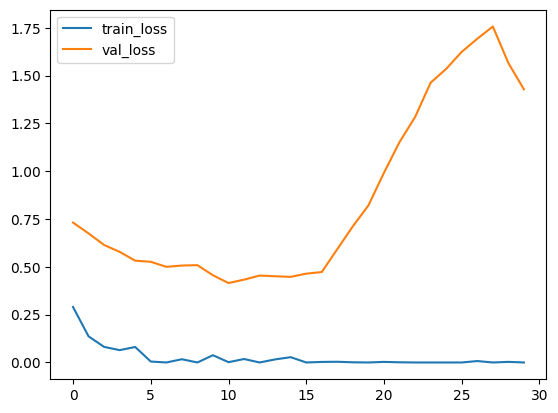

In [106]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [109]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if "tt" in i:
          dirFolder = fake_data_dir
          A = io.imread(os.path.join(dirFolder,i))
          
        else: 
          dirFolder = real_data_dir
          A = io.imread(os.path.join(dirFolder,i))

        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        A = io.imread(os.path.join(dirFolder,i))

        A = np.expand_dims(A, 0)
        A = torch.from_numpy(A.astype(np.int32)) / 255.0
        
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [110]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)

df_enc.to_csv("database.csv", index=False)

100%|██████████| 20000/20000 [07:28<00:00, 44.63it/s]


In [111]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,tt-cc/cin_k600_p1.0_a0.05_fid5.20/123/img00142...,-0.386885,-0.159944,-0.095635,0.474255,-0.024143,0.060721,-0.075461,0.125751,0.166956,...,0.063350,0.165658,0.007997,0.006388,0.366855,-0.089266,0.011096,0.198347,0.233434,0.177565
1,coco/coco2017/train2017/img151882.jpg,-0.089032,-0.352222,0.213468,-0.273075,-0.025238,0.076673,-0.414815,-0.179719,-0.096714,...,-0.060084,-0.212664,0.019323,0.029637,0.250751,-0.068037,-0.402050,-0.312947,0.085343,-0.026135
2,tt-cc/cin_k600_p1.0_a0.05_fid5.20/204/img00592...,0.018827,0.196003,-0.216049,0.202816,0.073126,0.308134,-0.061459,-0.079052,0.145198,...,0.331684,-0.118764,0.143006,-0.162533,-0.070651,-0.341676,0.074353,-0.199252,0.011603,-0.031260
3,tt-cc/cin_k600_p1.0_a0.05_fid5.20/32/img012335...,-0.052709,-0.259890,0.244601,-0.352018,0.273988,-0.034223,-0.265834,0.250429,-0.119506,...,-0.169591,-0.046467,-0.066461,-0.150524,0.301465,-0.206267,-0.533666,0.036065,0.100612,0.086662
4,coco/coco2017/test2017/img027932.jpg,0.622013,0.177384,-0.640546,0.462031,-0.159504,0.163098,0.026398,-0.027079,-0.030726,...,0.331738,-0.229187,0.345403,-0.673831,-0.457081,-0.175296,0.236602,-0.339990,-0.034838,-0.070516


In [112]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [113]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0       coco/coco2017/train2017/img152945.jpg
1       coco/coco2017/train2017/img051461.jpg
2       coco/coco2017/train2017/img052988.jpg
3       coco/coco2017/train2017/img057510.jpg
4        coco/coco2017/test2017/img027729.jpg
                        ...                  
3995     coco/coco2017/test2017/img022115.jpg
3996    coco/coco2017/train2017/img053091.jpg
3997    coco/coco2017/train2017/img125874.jpg
3998    coco/coco2017/train2017/img147836.jpg
3999    coco/coco2017/train2017/img056528.jpg
Name: real, Length: 4000, dtype: object
8000


,real,fake
0,coco/coco2017/train2017/img152945.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img049352.jpg
1,coco/coco2017/train2017/img051461.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img044542.jpg
2,coco/coco2017/train2017/img052988.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/848/img04163...
3,coco/coco2017/train2017/img057510.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img017600.jpg
4,coco/coco2017/test2017/img027729.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img001765.jpg


In [114]:
def getImageEmbeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [115]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [118]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

tempDf = df
tempDf.head()
tempDf.shape

(4000, 2)

In [119]:
# testo i fake
currentTest = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)

    if mode == "rgb":
        if "tt" in closestLabel:
            y_pred.append("fake")
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 4000it [24:13,  2.75it/s]


In [120]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
4000
['fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 

In [121]:
# testo i real
currentTest = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if "tt" in closestLabel:
            y_pred.append("fake")
            
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 4000it [24:05,  2.77it/s]


In [122]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
8000
['fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 

In [123]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * len(valid_df))
print(y_true.shape)

temp = np.array(["real"] * len(valid_df))
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(4000,)
(4000,)
(8000,)
[[1994 2006]
 [2007 1993]]


In [124]:
TN, FP, FN, TP = cm.ravel()

# metriche
accuracy = round((TP + TN) / (TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 49.84, 'Precision': 49.84, 'Recall': 49.82, 'Specificity': 49.85, 'F1 Score': 49.83}


In [126]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "siamese_rgb_taming_transformer_results.csv")

df_results.to_csv(path, index=False)